#### Bibliotecas e configuracoes

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

# Pacote com todas as funcoes devenvolvidas para esse projeto
from functions_proj_scraping import *

# Configs
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.precision', 2)
warnings.filterwarnings('ignore')

#### Pegar todos os anuncios de todas as paginas do site (macro) com paralelismo

In [2]:
url = 'https://www.lagoimobiliaria.com.br/pesquisa-de-imoveis/?locacao_venda=V&id_cidade%5B%5D=90&id_tipo_imovel%5B%5D=5&id_tipo_imovel%5B%5D=20&id_tipo_imovel%5B%5D=19&finalidade=residencial&dormitorio=0&garagem=0&vmi=&vma='
#url = 'https://www.lagoimobiliaria.com.br/pesquisa-de-imoveis/?locacao_venda=V&id_cidade%5B%5D=90&id_tipo_imovel%5B%5D=4&finalidade=0&dormitorio=0&garagem=0&vmi=&vma='
paginas = total_paginas_site(url)

base_geral = []

# Funcao para executar o scrapping
def processar_pagina(pag):
    soup = gerando_soup_principal(url, pag)
    pagina = soup.find('div', {'class':'properties_item_two row'}).findAll('div', class_='col-lg-3 col-md-4 col-sm-6 col-xs-12')
    
    resultados_pagina = []
    
    for item in range(0, len(pagina)):
        resultado = dados_pag_principal(pagina[item], item)
        resultados_pagina.append(resultado)
    
    return resultados_pagina

# Paralelismo
with concurrent.futures.ThreadPoolExecutor() as executor:
    resultados_paginas = list(executor.map(processar_pagina, range(paginas)))

# "Aplanhando" a lista de listas para obter uma única lista de resultados
base_geral = [resultado for resultados_pagina in resultados_paginas for resultado in resultados_pagina]

#### Carregando dados macro para dataframe e tratando dados

In [3]:
# Criando dataframe e Trocando Nan -> 0 e removendo duplicidades
df = pd.DataFrame(base_geral)
df.fillna(0, inplace=True)
df.drop_duplicates(subset=['link'], keep='first', inplace=True, ignore_index=True)

# Criando coluna com nro de indice para merge posterior
df['indice'] = df.index

# Corrigindo encoding no link para evitar erros
df['link'] = df.apply(lambda row: safeStr(row['link']), axis=1)

# Reindexando
df.reset_index(inplace=True, drop=True)

#### Pegando dados complementares de todos os anuncios com paralelismo

In [4]:
# Funcao para processar o scrapping de cada anuncio especificamente
def processar_anuncio(link, index):
    try:
        pagina = gerando_soup_anuncio(link)
        resultado = dados_pag_anuncio(pagina, index)
        if resultado != 'erro':
            return resultado
    except:
        pass
    return None

# Criando df com links para loop no paralelismo
links = pd.DataFrame(df['link'])

# Criando lista para gravar resultados
base_geral = []

# Usando paralelismo com limite de operacoes simultaneas
with concurrent.futures.ThreadPoolExecutor(max_workers=50) as executor:
    futures = {executor.submit(processar_anuncio, row['link'], index): index for index, row in links.iterrows()}

    # Coletando  e gravando os resultados na lista
    for future in concurrent.futures.as_completed(futures):
        resultado = future.result()
        if resultado:
            base_geral.append(resultado)

#### Carregando dados anuncios para dataframe, tratando dados e combinando bases

In [5]:
# Criando dataframe e trocando Nan -> 0
df2 = pd.DataFrame(base_geral) 
df2.fillna(0, inplace=True)

# Mesclando df + df2
base_final = df.merge(df2, how='inner', on='indice')
del df, df2

#### Tratando base final

In [6]:
# Criando coluna de preco
base_final['preco'] = np.where(base_final['valor']>=base_final['valor_venda'],
                               base_final['valor'],
                               base_final['valor_venda'])

base_final['preco'] = np.where(base_final['preco']==base_final['valor_aluguel'],
                               0,
                               base_final['preco'])

# Criando colunas de metragens
base_final['area_total_ou_terreno'] = np.where(base_final['area_total']==0,
                                               base_final['area_terreno'],
                                               base_final['area_total'])

base_final['area_util_ou_construida'] = np.where(base_final['area_util']==0,
                                                 base_final['area_construida'],
                                                 base_final['area_util'])

# Excluindo valores zerados
base_final = base_final[base_final['preco'] > 0]
base_final.drop(columns=['indice','valor_venda','valor','area_util','area_total',
                         'area_terreno','area_construida'], inplace=True)

# Convertendo tipagens numericas
base_final = tipagem(base_final)

# Convertendo objetos para categorias
colunas = ['bairro', 'cidade','classificacao','pagina']
base_final[colunas] = base_final[colunas].astype('category')

# Reindexando
base_final.reset_index(inplace=True, drop=True)

# Reorganizando
base_final = base_final[['bairro','cidade','descricao','link','link_foto_capa','classificacao','pagina',
                         'preco','quartos','suites','banheiros','vagas','itens_do_imovel', 'itens_do_condominio',
                         'area_total_ou_terreno', 'area_util_ou_construida','valor_condominio', 'valor_iptu','valor_aluguel']]

#### Removendo outliers

In [7]:
# Remocao de outliers
base_final = remove_outliers(base_final)

In [8]:
base_final.to_csv('base_final_anuncios.csv',sep=',', encoding='utf-8', index=False)

#### Plotando histogramas, boxplot e estatisticas descritivas das variaveis

In [9]:
#base_final = pd.read_csv('base_final_anuncios.csv', sep=',', encoding='utf-8')

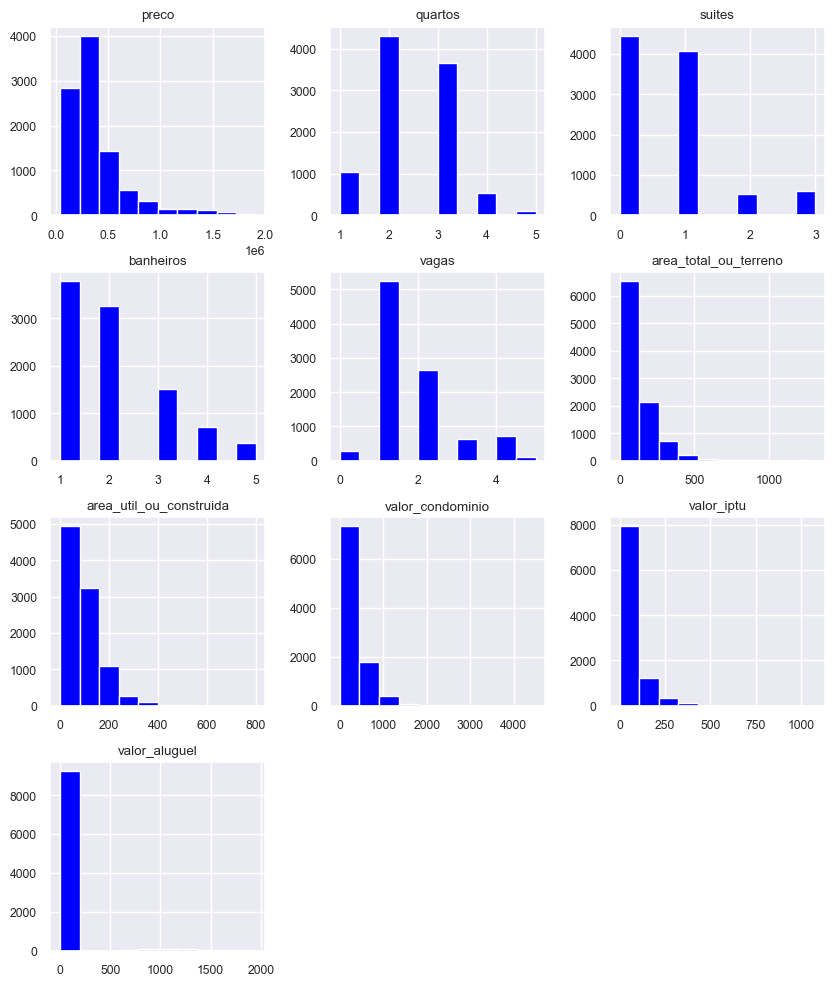

In [10]:
# PLOT DAS VARIAVEIS
sns.set(
    style='darkgrid', # ESTILO
    font_scale=0.8, # FONTE
    rc={'figure.figsize':(10,12)} # TAMANHO
)

graficos = base_final.hist(color='blue')

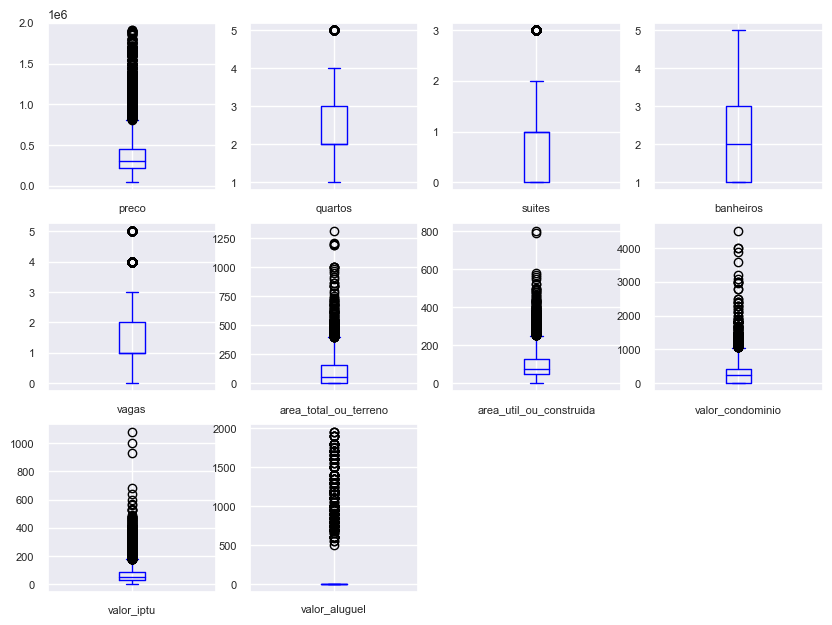

In [11]:
# BOXPLOT
boxplots = base_final.plot(kind='box', subplots=True, layout=(4,4), 
                           sharex=False, sharey=False, color='blue', 
                           figsize=(10,10), fontsize=8)

In [12]:
base_final.describe()

,preco,quartos,suites,banheiros,vagas,area_total_ou_terreno,area_util_ou_construida,valor_condominio,valor_iptu,valor_aluguel
count,9646.00,9646.00,9646.00,9646.00,9646.00,9646.00,9646.00,9646.00,9646.00,9646.00
mean,391289.16,2.42,0.72,2.03,1.65,99.51,97.78,287.58,68.99,49.83
std,289230.14,0.80,0.83,1.09,1.00,127.46,69.00,330.55,74.20,244.01
min,40000.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,212000.00,2.00,0.00,1.00,1.00,0.00,48.31,0.00,30.00,0.00
50%,298000.00,2.00,1.00,2.00,1.00,51.18,77.30,250.00,48.00,0.00
75%,450000.00,3.00,1.00,3.00,2.00,160.72,129.42,420.00,89.08,0.00
max,1910000.00,5.00,3.00,5.00,5.00,1309.41,800.00,4500.00,1080.00,1950.00
